In [113]:
# Data analysis libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [5]:
# Load flat file (Kaggle)
reviews_raw = pd.read_csv('beer_reviews.csv')

# Best Practice: Make a copy of the raw data to work on
reviews = reviews_raw.copy()

# Peep it
reviews.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [6]:
# reviews = reviews.drop(["review_time", "brewery_name", "beer_name"], axis=1)
reviews = reviews.drop(["brewery_name", "beer_name"], axis=1) # timestamp 살려두기

# Peep it
reviews.head()

,brewery_id,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_abv,beer_beerid
0,10325,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,5.0,47986
1,10325,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,6.2,48213
2,10325,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,6.5,48215
3,10325,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,5.0,47969
4,1075,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,7.7,64883


# 결측치 제거 및 수정
 - review_profilename      348개
 - brewery_name             15개 : 행 자체를 삭제했음
 - beer_abv              67785개 : 평균값이나 중앙값을 넣음 / 삭제하기에, 애주가에게 술의 도수는 너무 중요한 자료라고 판단 => 리뷰 총점과 연관성 분석 요망 by 상관계수 측정


In [7]:
# Convert 'object' to 'category' 
reviews[reviews.select_dtypes(['object']).columns] = reviews.select_dtypes(['object']).\
                                                         apply(lambda x: x.astype('category'))

# Examine structure 
reviews.info()

# Check for null values
print(reviews.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   brewery_id          1586614 non-null  int64   
 1   review_overall      1586614 non-null  float64 
 2   review_aroma        1586614 non-null  float64 
 3   review_appearance   1586614 non-null  float64 
 4   review_profilename  1586266 non-null  category
 5   beer_style          1586614 non-null  category
 6   review_palate       1586614 non-null  float64 
 7   review_taste        1586614 non-null  float64 
 8   beer_abv            1518829 non-null  float64 
 9   beer_beerid         1586614 non-null  int64   
dtypes: category(2), float64(6), int64(2)
memory usage: 105.7 MB
brewery_id                0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
re

In [10]:
# Percent of data missing `beer_abv` values
print("Percent Null Values of `beer_abv` column:", round(67785 / 1586614 * 100, 2),"%")

Percent Null Values of `beer_abv` column: 4.27 %


In [11]:
# Drop null row values
reviews = reviews.dropna()
reviews.info()

# Check for null values
print(reviews.isnull().sum())

# Percent of data that are null
print("Percent of Null Values:", round((1586614 - 1518478)/ 1586614 * 100, 2),"%")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1518493 entries, 0 to 1586613
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   brewery_id          1518493 non-null  int64   
 1   review_overall      1518493 non-null  float64 
 2   review_aroma        1518493 non-null  float64 
 3   review_appearance   1518493 non-null  float64 
 4   review_profilename  1518493 non-null  category
 5   beer_style          1518493 non-null  category
 6   review_palate       1518493 non-null  float64 
 7   review_taste        1518493 non-null  float64 
 8   beer_abv            1518493 non-null  float64 
 9   beer_beerid         1518493 non-null  int64   
dtypes: category(2), float64(6), int64(2)
memory usage: 112.8 MB
brewery_id            0
review_overall        0
review_aroma          0
review_appearance     0
review_profilename    0
beer_style            0
review_palate         0
review_taste          0
beer_a

약 7만개 날라감 : 전체 데이터 중에 널값 비율 = 4.29 %

# 중복 데이터 확인하기 
 - 같은 유저가 같은 맥주에 여러번 후기를 남긴 경우에 관한 고찰


In [12]:
# Sort by user overall rating first
reviews = reviews.sort_values('review_overall', ascending=False)

# Peep it
reviews.head()

,brewery_id,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_abv,beer_beerid
1586613,14359,5.0,4.5,4.5,cbl2,Pumpkin Ale,4.5,4.5,5.2,33061
302936,35,5.0,3.5,3.5,DonWalter,Fruit / Vegetable Beer,4.0,4.5,5.3,108
1226163,347,5.0,4.5,4.5,OStrungT,American Stout,5.0,4.5,6.7,3338
302907,35,5.0,3.5,4.0,BladeRunner,Fruit / Vegetable Beer,3.5,3.5,5.3,108
1226133,347,5.0,4.5,4.5,Adamdc,American Stout,4.0,4.5,6.7,3338


In [13]:

# Keep the highest rating from each user and drop the rest 
reviews = reviews.drop_duplicates(subset= ['review_profilename','beer_beerid'], keep='first')

# Peep structure
reviews.info()

# Percent of data that are duplicates
print("Percent of Duplicate Values:", round((1518478 - 1504037)/ 1518478 * 100, 2),"%")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1504052 entries, 1586613 to 653695
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   brewery_id          1504052 non-null  int64   
 1   review_overall      1504052 non-null  float64 
 2   review_aroma        1504052 non-null  float64 
 3   review_appearance   1504052 non-null  float64 
 4   review_profilename  1504052 non-null  category
 5   beer_style          1504052 non-null  category
 6   review_palate       1504052 non-null  float64 
 7   review_taste        1504052 non-null  float64 
 8   beer_abv            1504052 non-null  float64 
 9   beer_beerid         1504052 non-null  int64   
dtypes: category(2), float64(6), int64(2)
memory usage: 111.7 MB
Percent of Duplicate Values: 0.95 %


약 만4천개 데이터 날라감 : 결측치 제거한 후의 전체 데이터 중에 중복 데이터 비율 = 0.95 %

# 평점들의 분포도 확인하기 
 - 총점은 3.5 ~ 5에 가장 많이 분포
 - 향기 점수는 3.5 ~ 4.5 
 - 도수는 10도 내외에 가장 많이 분포


NameError: name 'plt' is not defined

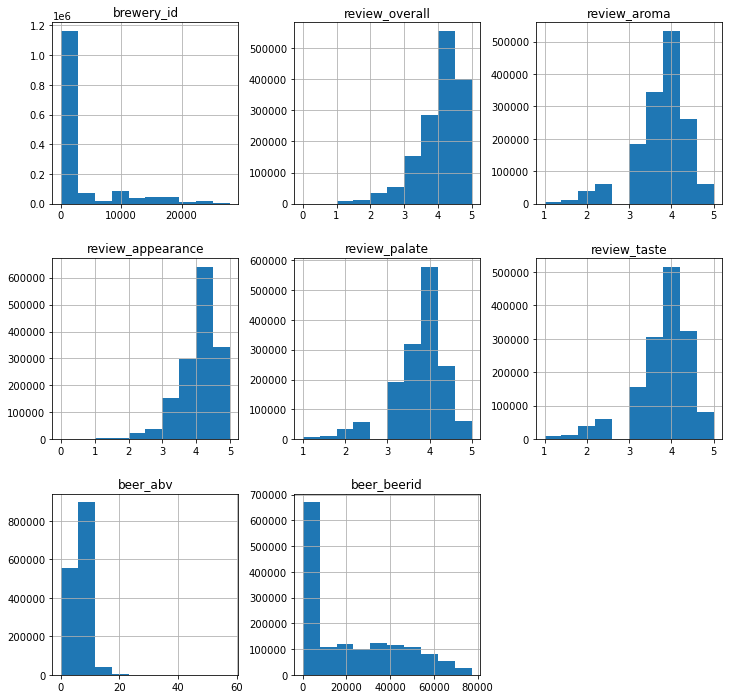

In [14]:
# Histogram of all numeric features
reviews.hist(figsize=(12,12))
plt.show()

# 리뷰 점수가 0점인 데이터 존재함 
 - 최저값이 0점인 피쳐 : review_overall, review_appearance
 - review_overall와 review_appearance는 서로 0이면 0인 필요충분 관계
 - 즉, 문제가 되는 0점 데이터는 8개 > 삭제해도 괜찮다는 추론 도출
 
 - beer_abv : 최저값 0.01


In [18]:
# Sort by user overall rating first
reviews = reviews.sort_values('review_overall', ascending=True)

# Peep it
reviews.head(8)

,brewery_id,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_abv,beer_beerid
386831,1933,1.0,3.5,4.0,brewdlyhooked13,American IPA,3.5,1.0,6.2,6765
1000535,435,1.0,2.0,2.5,hoplover82,American Pale Ale (APA),1.0,2.5,6.0,21007
1282532,335,1.0,2.0,3.0,maximum12,American Pale Ale (APA),2.0,1.0,6.0,62648
191665,1627,1.0,2.5,2.5,bahana,Fruit / Vegetable Beer,1.0,1.0,4.0,48953
1282522,335,1.0,1.0,3.0,GreenPea,American Pale Ale (APA),3.0,2.0,6.0,62648
883947,147,1.0,1.5,4.5,KeefD,American Double / Imperial IPA,1.0,1.5,8.9,59369
1181311,10099,1.0,2.5,4.0,ArrogantB,American Strong Ale,2.0,1.0,11.0,199
1282521,335,1.0,1.5,3.0,davidthebruce,American Pale Ale (APA),1.0,1.0,6.0,62648


In [16]:
# Sort by user overall rating first
reviews = reviews.sort_values('review_appearance', ascending=True)

# Peep it
reviews.head(8)

,brewery_id,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_abv,beer_beerid
653695,1412,0.0,2.0,0.0,beernut7,Hefeweizen,2.5,2.0,4.0,3788
653706,1412,0.0,3.0,0.0,beernut7,American Amber / Red Ale,2.5,3.5,4.0,3787
653726,1412,0.0,2.0,0.0,beernut7,German Pilsener,3.0,1.5,4.0,3822
39667,1413,0.0,3.0,0.0,beernut7,American Pale Ale (APA),2.0,2.0,4.0,3810
653740,1412,0.0,2.0,0.0,beernut7,Dunkelweizen,2.5,2.0,4.0,3786
39648,1413,0.0,4.0,0.0,beernut7,Irish Dry Stout,2.0,2.0,4.0,3804
37234,1413,0.0,2.0,0.0,beernut7,Czech Pilsener,3.0,2.0,4.0,3806
1309694,29,2.5,1.5,1.0,AndyAvalanche,American Adjunct Lager,2.5,3.0,5.0,65


In [17]:
reviews[(reviews['review_overall'] >= 1) | (reviews['review_appearance'] >= 1)].info()
print(1504052 - 1504045, "개의 데이터에 문제 발생")

# Review scores of >= 1
reviews = reviews[(reviews['review_overall'] >= 1) | \
        (reviews['review_appearance'] >= 1)]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1504045 entries, 1309694 to 1337909
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   brewery_id          1504045 non-null  int64   
 1   review_overall      1504045 non-null  float64 
 2   review_aroma        1504045 non-null  float64 
 3   review_appearance   1504045 non-null  float64 
 4   review_profilename  1504045 non-null  category
 5   beer_style          1504045 non-null  category
 6   review_palate       1504045 non-null  float64 
 7   review_taste        1504045 non-null  float64 
 8   beer_abv            1504045 non-null  float64 
 9   beer_beerid         1504045 non-null  int64   
dtypes: category(2), float64(6), int64(2)
memory usage: 111.7 MB
7 개의 데이터에 문제 발생


# 간단한 추천 : 총점만 사용 
 - review_overall > rating로 생각
 - 추천 모델 채택 : ...

In [19]:
# Create Pandas DF of ratings by user and item
ratings = reviews[['review_profilename', 'beer_beerid', 'review_overall']]

# Rename columns
ratings = ratings.rename(columns = {'review_profilename':'user', 
                                    'review_overall':'rating',
                                    'beer_beerid' : 'beer'
                                     })
ratings.head()

,user,beer,rating
386831,brewdlyhooked13,6765,1.0
1000535,hoplover82,21007,1.0
1282532,maximum12,62648,1.0
191665,bahana,48953,1.0
1282522,GreenPea,62648,1.0


In [50]:
# 고유 사용자, 고유 맥주 갯수 확인
n_users = len(ratings['user'].unique())
n_beers = len(ratings['beer'].unique())

n_users, n_beers

(32908, 49011)

#  To Do 유저별 리뷰 갯수 구하기

In [115]:
import collections, numpy 
#(collections.Counter(ratings['user'])

In [104]:
idx_reviewer = ratings.groupby('user').size().reset_index()

# ratings의 기술통계량 확인
ratings['rating'].describe()
idx_reviewer.columns = ["user", "count"]

idx_reviewer = idx_reviewer.sort_values(by="count", ascending=False)
idx_reviewer['count'] = pd.to_numeric(idx_reviewer['count'])
idx_reviewer.tail(480) #479명의 리뷰 데이터가 없음

#ratings[ratings['user'] == 'BRUKER']
idx_reviewer = idx_reviewer[idx_reviewer['count']>0]
idx_reviewer.reset_index()

#32908명의 리뷰어(리뷰를 작성한 유저)

idx_beers = ratings.groupby('beer').size().reset_index()
idx_beers.shape

#49011개의 맥주(리뷰받은 맥주)


(49011, 2)

In [109]:
user2idx = dict(zip(idx_reviewer.user, idx_reviewer.index.values))

beer2idx = dict(zip(idx_beers.beer, idx_beers.index.values))
idx2beer = dict(zip(idx_beers.index.values,idx_beers.beer))

ratings['beer_idx'] = [beer2idx.get(b) for b in ratings.beer]
ratings['user_idx'] = [user2idx.get(u) for u in ratings.user]

#ratings.loc[:, ['user_idx', 'beer_idx', 'rating']].as_matrix()

#n_users2 = len(user2idx) 
#n_beers2 = len(beer2idx) 

#n_users2, n_beers2 = n_users, n_beers = (32908, 49011)

(32908, 49011)

#  To Do Train-Test 데이터셋 분리

In [184]:
#
np.random.seed(3)
msk = np.random.rand(len(ratings)) < 0.8
train = ratings[msk].copy()
test  = ratings[~msk].copy()
print(df_train.head())
print(df_test.head())

                    user   beer  rating  beer_idx  user_idx
386831   brewdlyhooked13   6765     1.0      4029     16074
1000535       hoplover82  21007     1.0     11858     21379
1282532        maximum12  62648     1.0     38345     25171
191665            bahana  48953     1.0     29183     14519
1181311        ArrogantB    199     1.0       139       788
                 user   beer  rating  beer_idx  user_idx
1282522      GreenPea  62648     1.0     38345      5263
883947          KeefD  59369     1.0     36164      7109
1034003        mjc410   1361     1.0       866     25829
1307349     drpimento  27354     1.0     15557     19028
1064893  ChainGangGuy    750     1.0       496      2757


In [208]:
print(df_train.sort_values(by="user_idx", ascending=False))
print(df_train.sort_values(by="rating", ascending=False))
print(df_train.sort_values(by="beer_idx", ascending=False))

                    user   beer  rating  beer_idx  user_idx
2725        CzechThisOut  21521     5.0     19234     30678
1275694      geoffabrown  74452     5.0     35863     30677
591365           DrJones  10672     5.0       109     30676
889508         Adamblair  72138     5.0      5189     30675
886811       lewybrewing  38470     5.0      3293     30674
...                  ...    ...     ...       ...       ...
55045    brewdlyhooked13   1167     3.5      2410         0
425248   brewdlyhooked13  24751     3.5      1522         0
1567834  brewdlyhooked13  25231     3.5       997         0
1230406  brewdlyhooked13   8906     3.5      2650         0
386831   brewdlyhooked13   6765     1.0         0         0

[1202182 rows x 5 columns]
                    user   beer  rating  beer_idx  user_idx
1032167           junjun    131     5.0      2096       566
155305          SaCkErZ9  40058     5.0       466       969
933042           beerhan  17112     5.0      2660      2631
108822      

In [186]:
#인코딩
def proc_col(col, train_col=None):
    """ Encodes a pandas column with continous ids. """
    # Unique한 row를 찾는다 
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    # 사용자/영화를 인덱스와 매핑해준다
    name2idx = {o:i for i,o in enumerate(uniq)}
    # 그리고 그것을 포맷팅해서 리턴한다
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

In [189]:
# 다음은 실제로 데이터를 인코딩으로 만들어주는 함수이다
# 위에서 정의해준 proc_col을 사용한다
def encode_data(df, train=None):
    """ Encodes rating data with continous user and movie ids. 
    If train is provided, encodes df with the same encoding as train.
    """
    df = df.copy()
    for col_name in ["user_idx", "beer_idx"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _,col,_ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

In [191]:
# Test와 Validation인코딩을 만들어준다
df_train = encode_data(train)
df_val = encode_data(val, train)
print(df_train.head())
print(df_val.head())
"""                 user   beer  rating  beer_idx  user_idx
386831   brewdlyhooked13   6765     1.0      4029     16074
1000535       hoplover82  21007     1.0     11858     21379
1282532        maximum12  62648     1.0     38345     25171
191665            bahana  48953     1.0     29183     14519
1181311        ArrogantB    199     1.0       139       788
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
                    user   beer  rating  beer_idx  user_idx
386831   brewdlyhooked13   6765     1.0         0         0
1000535       hoplover82  21007     1.0         1         1
1282532        maximum12  62648     1.0         2         2
191665            bahana  48953     1.0         3         3
1181311        ArrogantB    199     1.0         4         4
"""

                    user   beer  rating  beer_idx  user_idx
386831   brewdlyhooked13   6765     1.0         0         0
1000535       hoplover82  21007     1.0         1         1
1282532        maximum12  62648     1.0         2         2
191665            bahana  48953     1.0         3         3
1181311        ArrogantB    199     1.0         4         4
                 user   beer  rating  beer_idx  user_idx
1282522      GreenPea  62648     1.0         2     23350
883947          KeefD  59369     1.0       104       330
1034003        mjc410   1361     1.0      2098       427
1307349     drpimento  27354     1.0        97      2149
1064893  ChainGangGuy    750     1.0        32        18


In [210]:
print(df_train.sort_values(by="user_idx", ascending=False))
print(df_train.sort_values(by="beer_idx", ascending=False))

                    user   beer  rating  beer_idx  user_idx
2725        CzechThisOut  21521     5.0     19234     30678
1275694      geoffabrown  74452     5.0     35863     30677
591365           DrJones  10672     5.0       109     30676
889508         Adamblair  72138     5.0      5189     30675
886811       lewybrewing  38470     5.0      3293     30674
...                  ...    ...     ...       ...       ...
55045    brewdlyhooked13   1167     3.5      2410         0
425248   brewdlyhooked13  24751     3.5      1522         0
1567834  brewdlyhooked13  25231     3.5       997         0
1230406  brewdlyhooked13   8906     3.5      2650         0
386831   brewdlyhooked13   6765     1.0         0         0

[1202182 rows x 5 columns]
                    user   beer  rating  beer_idx  user_idx
913846          Crosling  29103     5.0     45587      1188
914609       sholland119  60702     5.0     45586      3995
275080       unclejimbay  41712     5.0     45585      1928
21370       

#  임베딩 구하기 - 행렬분해 모델 학습

참고 : https://jyoondev.tistory.com/42 의 영화 학습 데이터

In [114]:
# 아래의 임베딩모델은 최대 10명의 사용자나 3개의 아이템에 대한 관계를 표현한다
# 임베딩의 숫자들은 랜덤으로 초기화 된다
embed = nn.Embedding(10, 3)
# 10명까지의 id이니 6개를 넣어준다
a = torch.LongTensor([[1,2,0,4,5,1]])
embed(a)

tensor([[[-0.4172,  0.5284, -0.3624],
         [-0.6857, -0.8056,  0.1686],
         [ 0.3055,  0.1045, -0.5124],
         [ 0.9345, -1.4353,  0.1459],
         [-0.7672, -0.3284, -1.0054],
         [-0.4172,  0.5284, -0.3624]]], grad_fn=<EmbeddingBackward0>)

In [151]:
# 아래는 PyTorch의 딥러닝을 제외한 기능을 사용해 만든 행렬분해 모델이다. 
# 임베딩 두개의 행 즉 벡터들을 각각 내적곱(Dot Product)을 하는 역할을 하는 모델이다.
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_beers, emb_size=100):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_size)
        self.item_emb = nn.Embedding(n_beers, emb_size)
        #  정규분포를 사용해 임베딩을 초기화한다
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)
    
    def forward(self, u, v):
        u = self.user_emb(u)
        v = self.item_emb(v)
        return (u*v).sum(1)

In [152]:
# 행렬분해 모델을 만든다
# 임베딩(특성)의 갯수는 100개로 한다
model = MatrixFactorization(n_users, n_beers, emb_size=100)
model

MatrixFactorization(
  (user_emb): Embedding(32908, 100)
  (item_emb): Embedding(49011, 100)
)

In [201]:
def validation_loss(model, unsqueeze=False):
    model.eval()
    users = torch.LongTensor(df_val.user_idx.values)
    items = torch.LongTensor(df_val.beer_idx.values)
    ratings_torch = torch.FloatTensor(df_val.rating.values)
    if unsqueeze:
        ratings_torch = ratings_torch.unsqueeze(1)
    y_hat = model(users, items)
    loss = F.mse_loss(y_hat, ratings_torch)
    print("validation loss {:.3f}".format(loss.item()))

In [202]:
def train_mf(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for i in range(epochs):
        users = torch.LongTensor(df_train.user_idx.values)
        items = torch.LongTensor(df_train.beer_idx.values)
        ratings_torch = torch.FloatTensor(df_train.rating.values)
        if unsqueeze:
            ratings_torch = ratings_torch.unsqueeze(1)
        y_hat = model(users, items)
        loss = F.mse_loss(y_hat, ratings_torch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.item()) 
    validation_loss(model, unsqueeze)

In [203]:
train_mf(model, epochs=10, lr=0.1)

14.663519859313965
5.6555562019348145
1.2709890604019165
4.694564342498779
0.6875664591789246
1.2846509218215942
2.7954671382904053
2.680150270462036
1.356416940689087
0.40893200039863586
validation loss 1.205


In [205]:
train_mf(model, epochs=15, lr=0.01)

1.1488553285598755
0.5829720497131348
0.37315139174461365
0.3864869475364685
0.46911242604255676
0.5237870812416077
0.524289071559906
0.4847681224346161
0.43181174993515015
0.38863301277160645
0.3671710193157196
0.3662164807319641
0.37541669607162476
0.3828246295452118
0.3813960552215576
validation loss 0.422


In [206]:
train_mf(model, epochs=15, lr=0.01)

0.3711617588996887
0.3505539000034332
0.3572334945201874
0.32865411043167114
0.32677778601646423
0.339814156293869
0.3351803123950958
0.3212461769580841
0.3177641034126282
0.3246026933193207
0.32765915989875793
0.32198581099510193
0.3152429759502411
0.3146364688873291
0.31778016686439514
validation loss 0.375


In [207]:
train_mf(model, epochs=20, lr=0.01)

0.3177810609340668
0.398337721824646
0.3197396397590637
0.3265382945537567
0.3539324402809143
0.33230382204055786
0.30918318033218384
0.31380730867385864
0.3274913430213928
0.32560449838638306
0.31183525919914246
0.30328309535980225
0.3069351613521576
0.31298577785491943
0.31059274077415466
0.3022870123386383
0.29735666513442993
0.298907607793808
0.30144795775413513
0.29941198229789734
validation loss 0.373
